<div style='border-bottom: 2px solid mediumblue; padding: 0.5em;'>
    <strong style='color: mediumblue; font-size: 30px;'>CLASSIFICATION.</strong>
    <br>
</div>

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
import pickle

import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv('../data/csv/train_dataset/df_clean.csv')

<div style="background-color: aliceblue; border: 1.5px solid blue; border-left: 5px solid blue; padding: 0.8em; font-size: 20px">
<strong>1. WORD EMBEDDINGS</strong>
</div>

<div style="background-color: blanchedalmond; border: 1.5px solid darkorange; border-left: 5px solid darkorange; padding: 0.5em; font-size: 16px">
<strong>1.1. Global Vectors</strong>
</div>

In [18]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [19]:
try:
    similar_words = glove_vectors.most_similar('cancer', topn=10)
    print("10 words most similar to 'cancer':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
except KeyError:
    print("'cancer' is not in the vocabulary.")

10 words most similar to 'cancer':
breast: 0.8210738301277161
prostate: 0.8065967559814453
disease: 0.7853677272796631
diabetes: 0.778843879699707
cancers: 0.7661833763122559
patients: 0.751171350479126
leukemia: 0.7485109567642212
alzheimer: 0.744443953037262
lung: 0.7317106127738953
diseases: 0.7292541265487671


To properly perform classification, we need the categories to be represented as integers rather than strings, so we map the column.

In [20]:
df['category'].unique()

array(['information', 'symptom', 'treatment', 'complication',
       'indication', 'diagnosis', 'organization', 'susceptibility',
       'prognosis', 'cause', 'association', 'contraindication',
       'genetic changes', 'inheritance', 'resources', 'prevention',
       'tapering', 'side effects', 'dosage'], dtype=object)

In [21]:
le = LabelEncoder()

In [22]:
df['category_encoded'] = le.fit_transform(df['category'])

In [23]:
df

,Unnamed: 0,qid,subject,message,focus,category,answer,user_query,category_encoded
0,0,1.0,lyme disease,12 years ago I was bitten by tick while deer h...,lyme disease,information,Lyme disease tests are used to determine if a ...,lyme disease 12 years ago I was bitten by tick...,8
1,1,2.0,raynauds syndrome,My sons middle toe turned white after being in...,raynauds syndrome,symptom,Only one finger or toe or parts of one or more...,raynauds syndrome My sons middle toe turned wh...,16
2,2,5.0,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,burn,treatment,"Before giving first aid, it is important to de...",burn to my wrist Hello I burnt my wrist 2 days...,18
3,3,6.0,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,parkinson,treatment,you should know that people who have Parkinson...,treatment of parkinson I AM HAVING PARKINSON F...,18
4,4,8.0,periventricular heterotopia. scoliosis - pos...,Question in laymen terms: Has any genetic or o...,"periventricular heterotopia, scoliosis",information,Isolated lissencephaly sequence (ILS) is a con...,periventricular heterotopia. scoliosis - pos...,8
...,...,...,...,...,...,...,...,...,...
441,441,Q196,NaN,Is there any information regarding adults havi...,inguinal hernia,information,Sometimes people inherit DNA mutations from a ...,Is there any information regarding adults hav...,8
442,442,Q197,outdated tetracycline,Is it safe to take outdated tetracycline?,obesity,treatment,"Diagnosing Leukemia: Physical Exam, Blood Test...",outdated tetracycline Is it safe to take outda...,18
443,443,Q198,duloxetine hcl dr,When is the best time of day to take Duloxetin...,ptsd,treatment,There are many treatment options for people wi...,duloxetine hcl dr When is the best time of day...,18
444,444,Q199,peptic ulcers & tylenol,"I have a history of peptic ulcers, so I don't ...",intraductal papilloma,treatment,"Unlike other types of cancer, leukemia isn't a...",peptic ulcers & tylenol I have a history of pe...,18


In [24]:
y = np.array(df['category_encoded'].values, dtype=int) 

Now again, we will tokenize the vectors.

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['user_query'].values)
sequences = tokenizer.texts_to_sequences(df['user_query'].values)
X = pad_sequences(sequences, maxlen=100)

In [26]:
print('Preprocessed text:', df['user_query'].values[100])
print('\nTokenized text:', sequences[100])
print('\nPadded text:', X[100])
print('\nPadded text Length: ', len(X[100]))

Preprocessed text: bone-joint degeneration in the hand or fingers? I notice that the joints or bones in my  hands hurt sharply when working, cooking and lately I have been dropping things from my left hand; even a sudden twist send shock thru my body-What is this?

Tokenized text: [1050, 378, 673, 10, 4, 440, 22, 1242, 1, 624, 19, 4, 1243, 22, 871, 10, 6, 872, 625, 2092, 59, 512, 2093, 2, 2094, 1, 9, 42, 2095, 256, 34, 6, 187, 440, 131, 5, 1239, 2096, 176, 1244, 1062, 6, 120, 20, 7, 15]

Padded text: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 1050  378
  673   10    4  440   22 1242    1  624   19    4 1243   22  871   10
    6  872  625 2092   59  512 2093    2 2094    1    9   42 2095  256
   34    6  187  440  131    5 1239 2096  176 1244 1062    6  120   

In [27]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.key_to_index:  # Updated to use .key_to_index
        embedding_matrix[i] = glove_vectors.get_vector(word)

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.22701   ,  0.1451    , -1.34800005, ..., -0.45699999,
         0.72389001,  0.49561   ],
       [ 0.44058999, -0.97942001, -0.83039999, ..., -0.64083999,
         0.41883999, -0.51876003],
       [ 0.09453   ,  0.010432  ,  0.73332   , ...,  0.1249    ,
         0.14628001, -0.58969003]])

In [28]:
num_categories = len(df['category'].unique())

In [29]:
model_lstm = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(128),
    Dense(num_categories, activation='softmax')])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          337400    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 457,099
Trainable params: 119,699
Non-trainable params: 337,400
_________________________________________________________________


2024-08-04 23:50:26.458487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-04 23:50:26.461267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-04 23:50:26.469564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [30]:
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial
history_lstm = model_lstm.fit(X, y, epochs=20, validation_split=0.2)

Epoch 1/20


2024-08-04 23:50:27.262863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-04 23:50:27.265454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-04 23:50:27.267407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - ETA: 0s - loss: 2.2941 - accuracy: 0.4270

2024-08-04 23:50:31.135152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-04 23:50:31.137555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-04 23:50:31.139965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 5s 191ms/step - loss: 2.2941 - accuracy: 0.4270 - val_loss: 2.2785 - val_accuracy: 0.4111
Epoch 2/20
12/12 [==============================] - 2s 136ms/step - loss: 1.9038 - accuracy: 0.4888 - val_loss: 2.0770 - val_accuracy: 0.4111
Epoch 3/20
12/12 [==============================] - 2s 134ms/step - loss: 1.8212 - accuracy: 0.4888 - val_loss: 2.1117 - val_accuracy: 0.4111
Epoch 4/20
12/12 [==============================] - 2s 134ms/step - loss: 1.7929 - accuracy: 0.4888 - val_loss: 2.0908 - val_accuracy: 0.4111
Epoch 5/20
12/12 [==============================] - 2s 135ms/step - loss: 1.7536 - accuracy: 0.4916 - val_loss: 2.1013 - val_accuracy: 0.4111
Epoch 6/20
12/12 [==============================] - 2s 133ms/step - loss: 1.7254 - accuracy: 0.4916 - val_loss: 2.1042 - val_accuracy: 0.4111
Epoch 7/20
12/12 [==============================] - 2s 135ms/step - loss: 1.6830 - accuracy: 0.4916 - val_loss: 2.1277 - val_accuracy: 0.4000
Epoch 8/20
12/12 

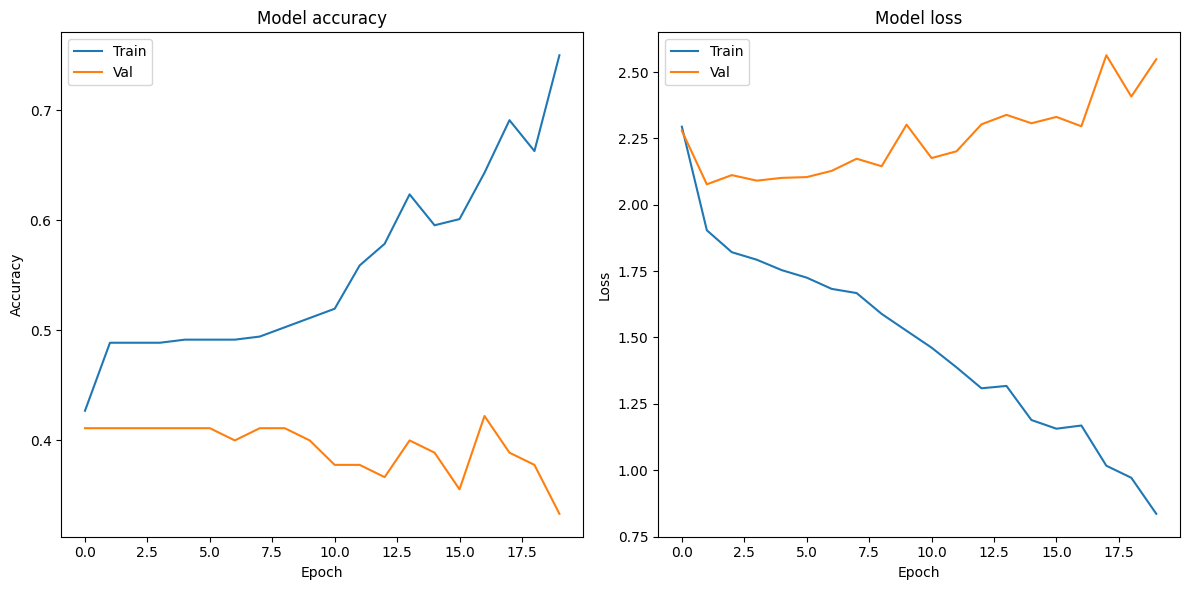

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [32]:

sequences_query = tokenizer.texts_to_sequences(np.array(["Are large, inoperable schwannomas treatable or able to be shrunk with chemotherapy or radiation?"], dtype=str))
X_query = pad_sequences(sequences_query, maxlen=100)

prediction = model_lstm.predict(X_query)
index_of_max = np.argmax(prediction)
unencoded_prediction = le.inverse_transform(np.array([index_of_max]))[0]
unencoded_prediction




2024-08-04 23:51:03.384509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-04 23:51:03.387088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-04 23:51:03.389364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 590ms/step


'treatment'

In [33]:
model_lstm.save('model_lstm_v_1.0.h5')

In [34]:
# Save the tokenizer
#with open('tokenizer.pkl', 'wb') as file:
#    pickle.dump(tokenizer, file)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)


In [35]:
from transformers import pipeline

pipe = pipeline("question-answering", model="pythonist/distilbert-base-uncased-finetuned-PubmedQA")

In [36]:
from transformers import pipeline

# Crear el pipeline para question-answering
pipe = pipeline("question-answering", model="pythonist/distilbert-base-uncased-finetuned-PubmedQA")

# Definir el contexto y la pregunta
context = """
The COVID-19 pandemic has had a significant impact on the global economy, with widespread unemployment and economic disruption.
Governments around the world have implemented various measures to mitigate the economic fallout, including fiscal stimulus packages and social support programs.
"""
question = "What has been the impact of the COVID-19 pandemic on the global economy?"

# Obtener la respuesta del pipeline
result = pipe(question=question, context=context)

# Imprimir la respuesta
print(f"Answer: {result['answer']}")


Answer: widespread unemployment and economic disruption.
Governments around the world have
